# Assignment 2: Quantization and Speech Coding
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 50

# Introduction

Throughout this assignment we will use the speech data in `data["speech8"]` which is sampled at 8 kHz. `speech8` will be used both for tuning (training, optimizing) and evaluating the speech coders (evaluating on the training data is called closed test evaluation). Normally this is considered inappropriate (why?), but
we accept it here for simplicity.
You will frequently be asked to evaluate the SNR which is calculated like
$SNR = 10 \log 10 \frac{\sigma_x^2}{\sigma_q^2}$, where $X(n)$ is input speech to the coder, and $q(n) =
X(n) − \hat{X}(n)$ is the quantization error, where $\hat{X}(n)$ is the quantized speech.
Thus, calculating the SNR amounts to estimating $\sigma_x^2$, and $\sigma_q^2$.
Please note that the last part of the assignment may be the most time
consuming. There you are asked to design a forward energy and filter adaptive
DPCM coder and you are not given many instructions. Make sure you allocate
enough time for this last part!

## The Uniform Scalar Quantizer (4 pts)

In this task we implement the simplest quantizer of all: the uniform scalar
quantizer (USQ). USQs will be used frequently in this assignment.
Encoding and transmission by USQ is sometimes called Pulse Code Modulation (PCM).

In [1]:
import pickle as pkl
import numpy as np

def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d

assignment_file = "assignment2.pkl"
data=read_assignment_file(assignment_file)

# the speech data is data["speech8"]


### Question 1（2 pts)

Implement a uniform scalar encoder:

In [2]:

def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
    so that the width of each quantization interval is ∆ = 2 × xmax/L,
    where L is the number of quantization intervals and corresponding reconstruction values.
    m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """
    
    L = 2**n_bits     # number of intervals
    dx = 2*xmax/L       # width of intervals

    idx = (xin+m)//dx + L/2
    idx = np.clip(idx, 0, L-1)
    idx = [int(i) for i in idx]
    
    return idx

"""Setting m = 0 defines a “midrise” quantizer, and m = $\frac{\Delta}{2}$ 
gives a "midtread" quantizer (see the course book sec. 7.2)."""

#Implement also the corresponding decoder function

def sq_dec(idx, n_bits, xmax, m):
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """    
    
    L = 2**n_bits
    dx = 2*xmax/L
    xhatmax = (L-1)*dx/2 - m
    xhatmin = -xhatmax -2*m

    recon_levels = np.linspace(xhatmin, xhatmax, L)    
    outq = [recon_levels[i] for i in idx]
    
    """
    L = 2**n_bits
    del_x = 2*xmax/L
    xhat_max = (L-1)*del_x/2 - m
    xhat_min = -((L-1)*del_x/2 + m)

    recon_levels = np.linspace(xhat_min, xhat_max, L)

    outq = [recon_levels[i] for i in idx]
    """
    
    return outq

The USQ is a highly structured quantizer. The encoder can be imple-
mented essentially by only a scalar division (no multiplications, compar-
isons or loops are needed), making the computational complexity inde-
pendent of the bitrate. Make sure your encoder has a computational
complexity independent of the bitrate!

### Question 2 (2 pts)

Run the encoder and decoder on a ramp signal `x=np.linspace(-6,6,1201)`. Use a `2-bit` quantizer with $x_{max} = 4$. 

Plot the quantizer output as a function of the input. 

Make sure the output levels are exactly where you expect them to be.

Use a quantizer mean $m=0$. Do a similar plot with $m=1.5$.

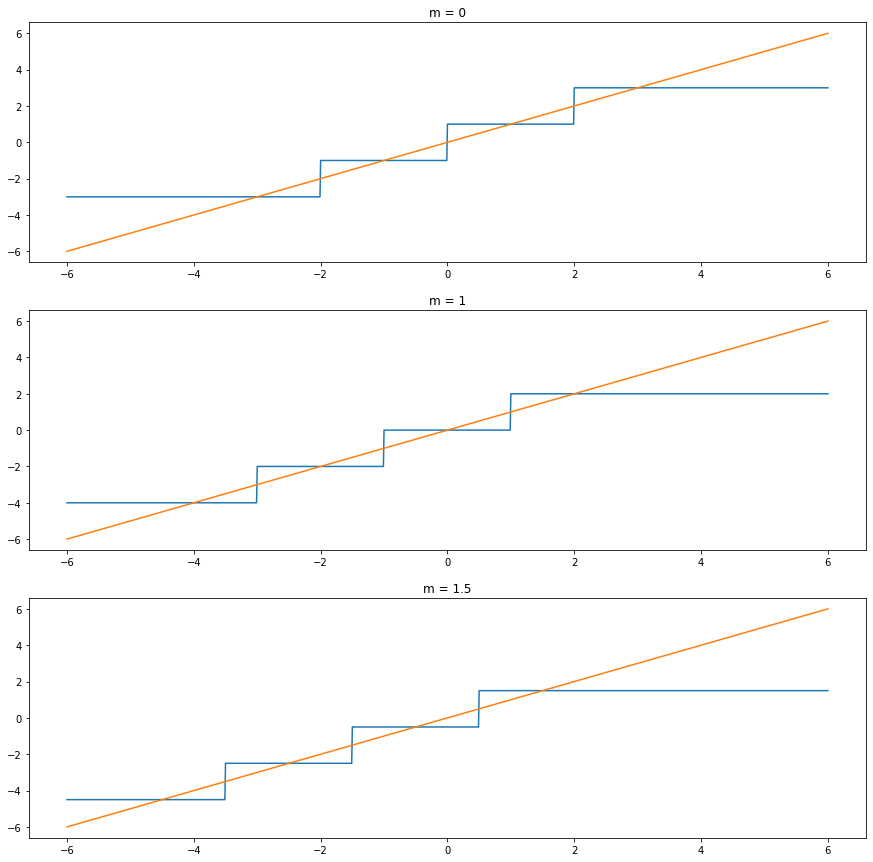

In [3]:
import matplotlib.pyplot as plt

x=np.linspace(-6,6,1201)


c = sq_enc(x,2,4,0)
v = sq_dec(c, 2, 4, 0) # xin, nbits, xmax, m

c2 = sq_enc(x,2,4,1)
v2 = sq_dec(c2, 2, 4, 1) # xin, nbits, xmax, m

c3 = sq_enc(x,2,4,1.5)
v3 = sq_dec(c3, 2, 4, 1.5) # xin, nbits, xmax, m


fig, axs = plt.subplots(3, figsize= (15,15))
axs[0].set_title("m = 0")
axs[0].plot(x,v)
axs[0].plot(x,x)

axs[1].set_title("m = 1")
axs[1].plot(x,v2)
axs[1].plot(x,x)

axs[2].set_title("m = 1.5")
axs[2].plot(x,v3)
axs[2].plot(x,x)


## Parametric Coding of Speech (23 pts)

In this task we complete our design of the vocoder from assignment 1.
Note that the speech used in this assignment is different from assignment 1 and if
your vocoder analysis is not robust you may have to retune the analysis for this
assignment.
You are encouraged to use your vocoder from assignment 1. This means reuse the functions "analysis"..., "synthesis"...

In practice, a speech coder must operate on a frame-by-frame basis, and transmit compressed data as quickly as possible in order to keep the delay short.
However, you may have implemented your vocoder in an off-line fashion (the pitch estimator is easier to implement like that for example). 


In [4]:
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.linalg import solve_toeplitz, toeplitz
import pickle as pkl
from scipy.io import wavfile
import numpy as np
from scipy.signal import firwin,filtfilt


def analysis(x, alen, ulen, M):
    naf = ((len(x)-alen+ulen)//ulen)
    # Initialization
    E = np.zeros((naf, 1))
    ZC = np.zeros((naf, 1))
    V = np.zeros((naf, 1))
    A = np.zeros((naf, M+1)) # M is the prediction order.
    # M+1 allows space for the leading 1
    P = np.zeros((naf, 1))
    th = .12 # binary decision threshold
        
    for n in range(0,naf):
        sum = 0
        offset = n*ulen    # index of analysis window starts from offset
        xw = x[offset:offset+alen]*signal.windows.hann(alen) # current window
        zcCount = 0     # crossing count
        for i in range(1,alen-1):
            sum = sum + xw[i]**2   # for frame energy
            if (xw[i]*xw[i-1] <0):
                zcCount += 1
        E[n] = sum/alen      # energy normalized by frame length
        ZC[n] = zcCount/alen  # The normalized number of zero crossings
        V[n] = (ZC[n]<th)     # Equal to 1 if voiced, 0 if unvoiced.

        # filter coefficients
        lags, r = xcorr(xw,xw,M=M)
        a=np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])])  # LP coefficients
        A[n,:] = a  # Make sure the polynomial coefficients are in a row vector!
        
        g = np.gradient(r)
        
        #finds first peak:
        for j in range(len(g)-1):
            if ((g[j]*g[j+1] < 0) and r[j]>0):
                P[n] = j # Pitch period in samples 
                break

    return E, ZC, V, A, P

def synthesis(E, ZC, V, A, P, ulen):
    n_frames = A.shape[0] # Assuming filter coefficients are stored row-wise
    
    # Create noise excitation:
    mean = 0
    std = 1
    nexc = np.random.normal(mean,std, size = n_frames*ulen)
    n1 = 0
    Z = np.array([])              # state vector/initial conditions/filter delay values
    s = np.zeros((n_frames*ulen)) # synthesis frame
    pexc = np.zeros((n_frames*ulen))
    
    for n in range(0, n_frames):   
        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter        
        
        if V[n]: # if voiced
            for i in range(n*ulen, (n+1)*ulen):
                if i%P[n] == 0:
                    pexc[i] = 1
            exc = pexc

        else: exc = nexc # else unvoiced
                        
        if Z.shape[0] == 0: # 1st iteration
            frame = signal.lfilter(np.array([1]), A[n,:], exc[n1:n1+ulen])
            Z = signal.lfiltic(np.array([1]), A[n,:], s[n1:n1+ulen], x=exc[n1:n1+ulen])
        else:
            frame,Z = signal.lfilter(np.array([1]), A[n,:], exc[n1:n1+ulen], zi=Z)
            
        #Normalize energy
        Es = sum(frame**2)/ulen # Frame energy normalized by number of samples
        frame = frame * np.sqrt(E[n]/Es)
        s[n1:n1+ulen] = frame

        n1 = n1+ulen    
    return s

def xcorr(x,y,M=10):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]

def read_wav(fname):
    raw_data=wavfile.read(fname)
    return raw_data[1].astype(np.float32), raw_data[0]

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)

def lowpass(x,fc,fs=44100):
    """ x is the signal, 
        fc is the cuttoff frequency expressed in Hz, must be between [0,fs/2]
    """
    b = firwin(1024, fc,fs=fs)
    y = filtfilt(b,1,x)
    return y

### Quantizing the Frame Energy (8 pts)

#### Question 1 (1 pts)

Provide a plot of the histogram of the energy parameter.
Indicate in the plot the range of the quantizer, i.e., mark the outer boundaries $m\pm xmax$ (also mark m).
Note that the pdf has a non-zero mean.

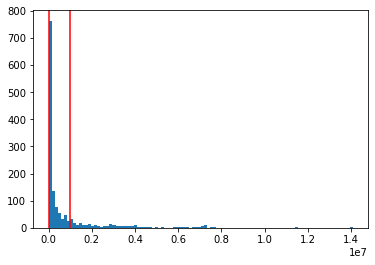

In [5]:

x = data["speech8"].reshape(-1)
alen = 256
ulen = 32
M = 50

E, ZC, V, A, P = analysis(x, alen, ulen, M)

xmax = 5e5
m = -5e5

plt.hist(E, bins= 100)
plt.axvline(-m+xmax,color ="red")
plt.axvline(-m-xmax,color="red")

#### Question 2 (2 pts)

Run the vocoder with a uniform scalar energy quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.

In [6]:

x = data["speech8"].reshape(-1)
alen = 256
ulen = 32
M = 10

n_bits = 8
xmax =5e5
m = -5e5
enc = sq_enc(E,n_bits,xmax, m)
dec = sq_dec(enc,n_bits,xmax,m)

s = synthesis(dec, ZC, V, A, P, ulen)
play_wav(s,8000)

#### Question 3 (1 pts)

Take the logarithm of the energy parameter prior to quantization (does not matter which base).
Provide a plot of the histogram of the energy parameter in the log-domain.
Indicate the range of this quantizer as above.

(array([763., 136.,  76.,  54.,  33.,  46.,  24.,  32.,  18.,  12.,  17.,
         11.,   9.,  15.,   7.,  10.,   5.,   3.,   5.,   5.,  14.,  10.,
          5.,   5.,   6.,   7.,   5.,   7.,  10.,   3.,   4.,   2.,   3.,
          2.,   0.,   3.,   0.,   3.,   1.,   1.,   1.,   2.,   2.,   4.,
          2.,   2.,   1.,   2.,   3.,   2.,   5.,   9.,   1.,   4.,   2.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          2.]),
 array([5.27596127e+00, 1.40877758e+05, 2.81750241e+05, 4.22622723e+05,
        5.63495206e+05, 7.04367688e+05, 8.45240170e+05, 9.86112653e+05,
        1.12698514e+06, 1.26785762e+06, 1.40873010e+06, 1.54960258e+06,
        1.69047506e+06, 1.83134755e+06, 1.97222003e+06, 2.11309251e+06,
        2.25396499e+06, 2.3948

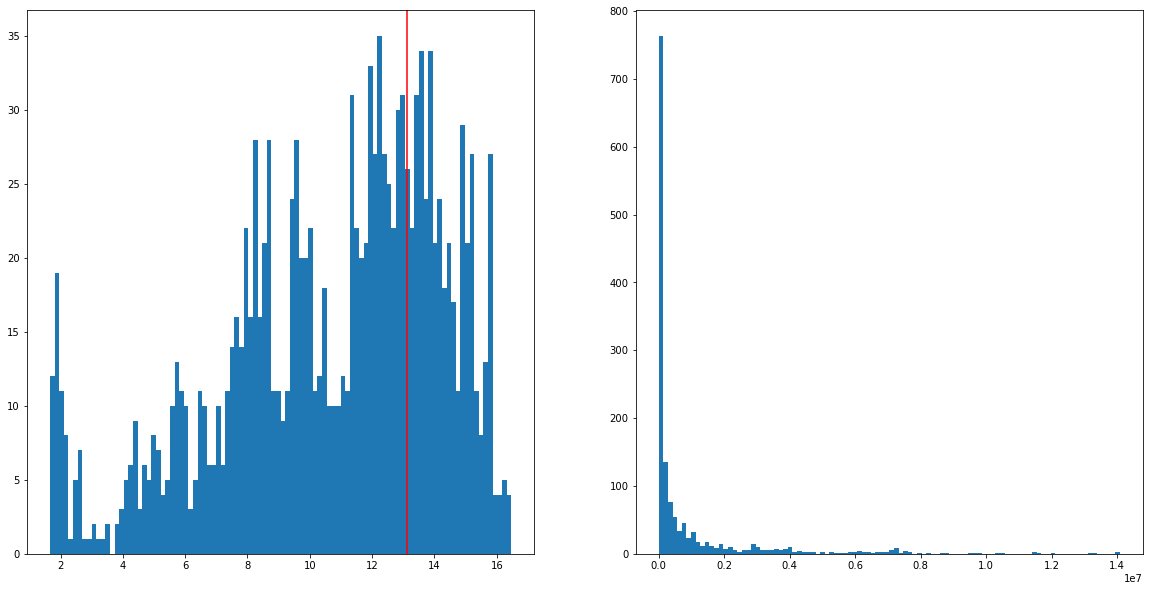

In [7]:
x = data["speech8"].reshape(-1)
alen = 256
ulen = 32
M = 10

E, ZC, V, A, P = analysis(x, alen, ulen, M)

Elog = np.log(E)

fig,ax = plt.subplots(1,2, figsize = (20,10))
ax[0].hist(Elog,bins=100)
ax[0].axvline(np.log(5e5), color = "red")
ax[1].hist(E,bins = 100)

#plt.hist(Elog, bins= 100)


#### Question 4 (2 pts)

Run the vocoder with a uniform scalar log-energy quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.
Make sure to modify the decoder accordingly (apply the exp function to the quantized log-energy).

In [8]:
x = data["speech8"].reshape(-1)
alen = 256
ulen = 32
M = 30

E, ZC, V, A, P = analysis(x, alen, ulen, M)
Elog = np.log(E)

n_bits = 8
xmax = 5e5
logxmax = np.log(xmax)
m = 0

enc = sq_enc(Elog,n_bits,logxmax, m)
dec = sq_dec(enc,n_bits,xmax,m)

s = synthesis(dec, ZC, V, A, P, ulen)
play_wav(s,8000)


<ipython-input-4-ae1ad18dcd5a>:69: RuntimeWarning: invalid value encountered in remainder
  if i%P[n] == 0:


#### Question 5 (2 pts)

Which is better: energy quantization in linear or log domain?

### Quantizing the Pitch and Voiced/Unvoiced Decision (2 pts)

#### Question 1 (2 pts)

Come up with an efficient way to encode the pitch and voiced/unvoiced decision.

In [9]:
def encodepitch(P,):
    penc = (P//2)*2
    return penc

def encodeV(V):
    v = V.copy()
    v.append(2)
    L = len(v)
    j=0
    l = []
    while j < L-1:
        nones = 0
        nzeros = 0
        while v[j] == 1:
            nones += 1
            j = j+1
        l.append(nones)
        while not v[j]:
            nzeros += 1
            j = j+1
        l.append(nzeros)
    
    Venc = np.array(l)
    Venc = Venc[Venc != 0]
    
    #V.pop[j]
    start = V[0]
    return Venc, start

def decodeV(Venc, start):
    n = start
    vdec = []
    for i in Venc:
        vdec = np.pad(vdec,(0,i),'constant', constant_values = n)
        n = 1-n
    return vdec

        

In [10]:
# voiced/unvoiced encoding test

V = [0,0,0,1,1,0,1,0,1,1,0,1]
venc, start = encodeV(V)
vdec = decodeV(venc,start)
print(f"V: {V}")
print(f"venc:  {venc}")
print(f"vdec {vdec}")

V: [0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]
venc:  [3 2 1 1 1 2 1 1]
vdec [0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.]


(array([ 83.,   0.,   0.,   0.,   0.,   0.,   0., 206.,   0.,   0.,   0.,
          0.,   0.,   0.,  82.,   0.,   0.,   0.,   0.,   0.,   0.,  59.,
          0.,   0.,   0.,   0.,   0.,   0.,  70.,   0.,   0.,   0.,   0.,
          0.,   0., 187.,   0.,   0.,   0.,   0.,   0.,   0., 195.,   0.,
          0.,   0.,   0.,   0.,   0., 103.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 157.,   0.,   0.,   0.,   0.,   0.,   0., 133.,   0.,
          0.,   0.,   0.,   0.,   0.,  71.,   0.,   0.,   0.,   0.,   0.,
          0.,  33.,   0.,   0.,   0.,   0.,   0.,   0.,  21.,   0.,   0.,
          0.,   0.,   0.,   0.,  25.,   0.,   0.,   0.,   0.,   0.,   0.,
          6.]),
 array([ 0.  ,  0.28,  0.56,  0.84,  1.12,  1.4 ,  1.68,  1.96,  2.24,
         2.52,  2.8 ,  3.08,  3.36,  3.64,  3.92,  4.2 ,  4.48,  4.76,
         5.04,  5.32,  5.6 ,  5.88,  6.16,  6.44,  6.72,  7.  ,  7.28,
         7.56,  7.84,  8.12,  8.4 ,  8.68,  8.96,  9.24,  9.52,  9.8 ,
        10.08, 10.36, 10.64, 10.92

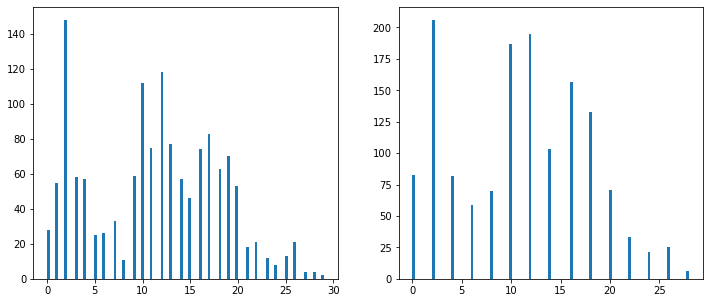

In [11]:
# pitch period encoding test

x = data["speech8"].reshape(-1)
alen = 256
ulen = 32
M = 30

E, ZC, V, A, P = analysis(x, alen, ulen, M)

penc = (P//2)*2
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(P, bins =100)
ax[1].hist(penc, bins =100)
    

### Quantizing the LP parameters (4 pts)

#### Question 1 (4 pts)

For the quantization of LP parameters, we will use a vector quantizer (VQ).
You do not need to optimize (train) the VQs; that has been done for you, and
the codebooks can be found in the given data 'lsfCB1' and 'lsfCB2' in
the file assignment2.pkl
The codebooks constitute a multistage VQ. 
`lsfCB1` is a 10 bit VQ optimized on 10 dimensional LSF vectors. 
`lsfCB2` is a 10 bit second stage residual codebook.
You extract these codebooks by calling data['lsfCB1'], data['lsfCB2']

What you need to do is to program an encoding function and a corresponding decoding function for a multistage VQ. 
A suitable calling syntax for these functions can be

```python
def encodefilter(A, cb1, cb2):
    return codeA
```

```python
def decodefilter(codeA, cb1, cb2):
    return Aq
```

Here A is a matrix with filter coefficients stored row-wise, and codeA is a two-column matrix with the corresponding code indices, stored row-wise.

Notes:

1. To convert between polynomial (a-) coefficients and LSFs see `poly2lsf` and `lsf2poly`. You migh require toolboxes such as https://pyspectrum.readthedocs.io/en/latest/install.html

2. `poly2lsf` requires the polynomial coefficients to correspond to a minimum phase whitening filter. 
This is guaranteed by the autocorrelation LP analysis.
`lsf2poly` requires that the LSFs correspond to a minimum phase whitening filter.
The multistage VQ can output LSFs that do not satisfy this.
As a precaution simply sort the LSFs prior to calling `lsf2poly`.
Also check so they are between 0 and $\pi$.

In [94]:
from scipy.spatial.distance import cdist
from spectrum import lsf2poly, poly2lsf

def encodefilter(A, cb1, cb2):
    
    lsf = np.zeros((A.shape[0], A.shape[1]-1))

    for i in range(A.shape[0]):
        lsf[i,:] = poly2lsf(A[i,:])
        
    dist = cdist(lsf, cb1, 'euclidean') # squared error distortion 

    x_opt = []
    x_idx = []
    for row in dist:
        idx = np.argmin(row)   # optimal vector
        x_idx.append(idx)     
        x_opt.append(cb1[idx])
        
    res = x_opt-lsf     # residual error            
    rdist = cdist(res, cb2, 'euclidean')

    d_idx = []
    for row in rdist:
        d_idx.append(np.argmin(row))   # indices of d_opt
    
    codeA = np.transpose([x_idx,d_idx])
    print(np.shape(codeA))
    
    return codeA

#def decodefilter(codeA, cb1, cb2):
 #   return Aq

In [96]:
cb1 = data['lsfCB1']
cb2 = data['lsfCB2']

x = data["speech8"].reshape(-1)
alen = 256
ulen = 32
M = 10

E, ZC, V, A, P = analysis(x, alen, ulen, M)

codeA = encodefilter(A, cb1, cb2)

(1431, 2)


### Optimizing the Bit Allocation (9 pts)

Here you experiment a little with the number of bits to use for each parameter.
Since you are provided with the LSF codebooks, you cannot experiment with the number of bits spent on LP parameter quantization.
LP quantization contributes a lot to the total number of bits, and the choice of LSF codebook size
vs. performance is crucial in vocoder design, but here we keep the LSF codebook
size fixed.
Find a bit allocation (i.e. the number of bits to use in each quantizer) for the energy, pitch, voiced/unvoiced quantizers, such that the quality is the same as when these parameters are unquantized (the effect of the LP parameter quantization is always present).

#### Question 1 (2 pts)

Evaluate the SNR for your design above.

#### Question 2 (3 pts)

What number of bits do you suggest for the pitch? For the energy? For the
voiced/unvoiced decision?

#### Question 3 (2 pts)

What is the rate in bits per sample of your vocoder with the bit allocation
suggested above? In bits per second?

#### Question 4 (2 pts)

Does it make sense to evaluate SNR here? Why or why not?

## Speech Waveform Quantization (10 pts)

#### Uniform Scalar Quantization of Speech

We will in the following design our quantizers using $x_{max} = \sigma_Xk$ , where $\sigma_X$
is the variance of speech and k is an experimentally tuned parameter (here it is tuned to maximize SNR). 

`k` is rate dependent and the SNR optimal `k` for rates 1 to 16 are
```python
l=[0.95, 2.1, ?, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2,
11.15, 11.15]
```

The optimal (in terms of SNR) value for $R = 3$ is to be found experimentally.
Run the quantizer with different values of k, and measure the SNR, to find the optimal choice.

##### Question 1 (2 pts)

Evaluate the optimal `k` for $R = 3$.

##### Question 2 (2 pts)

Run the quantizer at rates [16, 15, 14, . . ., 2, 1], and evaluate the SNR
for each rate.
Provide a plot of the SNR as a function of rate.

##### Question 3 (2 pts)

Provide a graph of the theoretical SNR in the same plot as the experimental SNR plot.
For the theoretical SNR, assume that the number of quantization levels is high, and that overload is negligible.

##### Question 4 (1 pts)

At what rate can you not tell the difference between the original and the quantized signal?

##### Question 5 (1 pts)

Listen to the quantization error signal, $q(n)$. 
How would you characterize $q(n)$ for a system operating at rate $R = 1$.
Increase the rate (up to $R \approx 12$) and describe how the character of $q(n)$ changes.

##### Question 6 (OPTIONAL 2 pts)

Is it advantageous to have a reconstruction level in the origin for low rates?
Compare (by listening) midrise and midtread quantizers at low bit rates.

## Adaptive Open-Loop DPCM (13 pts)
<img src="./openloopdcm.png" alt="alt text" width="800"/>

In this section we will study open-loop Differential Pulse Code Modulation (DPCM).
Open loop DPCM can be viewed as pre-filtering, quantization, and post-filtering, see Figure 1 (the adaptation
mechanism is not shown). 
It is called open loop because the quantizer is not part of the prediction loop.

We will want to adapt both the LP coefficients and the energy in a forward fashion.
See the vocoder section for hints on how to forward adapt those.
In general the structure of open loop DPCM is similar to the vocoder structure with
one important difference: vocoders create an artificial replica of the prediction
error signal $d(n)$ (by estimating voiced/unvoiced, the pitch, energy), whereas
open loop DPCM coders quantize each sample of the prediction error signal
and thus try to preserve the original waveform. 

We recommend that you reuse as much as possible of the code from the vocoder.

#### Question 1 (4 pts)
You are not given many guidelines here. Give it your best shot and make
sure you can motivate your choice of for example
- analysis frame length,
- update length (to keep things simple make analysis and update lengths
equal, i.e., no overlapping analysis frames),
- window function (for the analysis of certain parameters),
- number of bits to quantize the energy,
- number of bits to quantize the residual,
Use the VQ as before to quantize the LP parameters (thus, you need not
decide prediction order!).

Design the PCM quantizer for the prediction error d(n) according to
$x_{max} = k \sigma_d$ . 
Optimize k for $R = 3$ (R meaning the rate of the residual quantizer), by experimenting, so that it sounds good, i.e., do not optimize SNR theoretically.

#### Question 2 (1 pts)

Run your system at R = 3. 
How would you characterize the reconstructed speech? What does the quantization error sound like?


#### Question 3 (2 pts)

What shape does the quantization error spectrum have? 
Plot a DFT based spectrum of the error for a voiced frame. 
What does theory say?

#### Question 4 (2 pts)

Measure the SNR of your system. 
Compare with the SNR of PCM at the same rate.
Comments?

#### Question 5 (2 pts)

What is the total rate of your coder in bits per sample? In bits per second?

#### Question 6 (2 pts)

Is it better to use the quantized LP coefficients in the encoder filter than to use the unquantized LP coefficients?